# Denoising autoencoders

In [ ]:

import matplotlib
# save plot in the background
# matplotlib.use("Agg")
import tensorflow as tf
#from pyimagesearch.convautoencoder import ConvAutoencoder as Cauto
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

In [ ]:
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [ ]:
import skimage
from PIL import Image


def preprocess(array,w=28,h=28,c=1):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """
    array = array/255.0
    #print(array)
    #array = tf.image.decode_jpeg(array, channels=1)
    
    array = tf.convert_to_tensor(array,dtype=tf.float32)
    return array

# def noise(array):
#     """
#     Adds random noise to each image in the supplied array.
#     """

#     noise_factor = 0.4
#     noisy_array = array + noise_factor * np.random.normal(
#         loc=0.0, scale=1.0, size=array.shape
#     )
#     noisy_array = noisy_array - noise_factor * np.random.normal(
#         loc=0.0, scale=1.0, size=array.shape
#     )

#     return np.clip(noisy_array, 0.0, 1.0)
def noise(img, s = 69):
        img = skimage.util.random_noise(img, mode="gaussian", seed = s)
        img = skimage.util.random_noise(img, mode="s&p", seed = s)
        img = skimage.util.random_noise(img, mode="localvar", seed = s)
        return img

def dis(array1, array2,w=28,h=28):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(w, h))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(w, h))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

(60000, 28, 28)
(28, 28)
<class 'numpy.ndarray'>


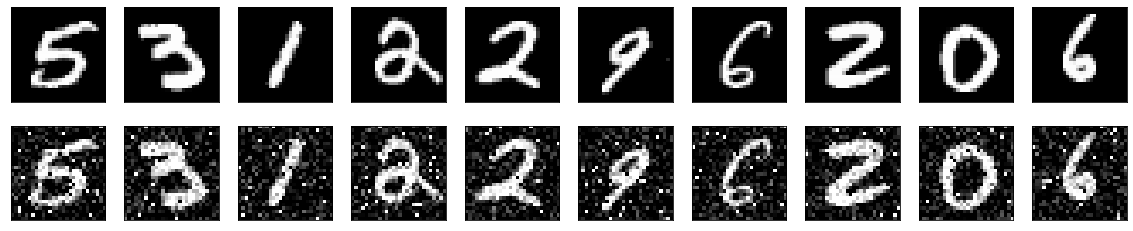

In [ ]:
# We will not be using labels since this is not a classification project



(train_data, _), (test_data, _) = mnist.load_data()
print(train_data.shape)
# Normalize and reshape the data
print(train_data[0].shape)
print(type(train_data[0]))


# Add noise to the data
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display both version of the img data
dis(train_data, noisy_train_data)

In [ ]:
shape = train_data[0].shape
shape

(28, 28)

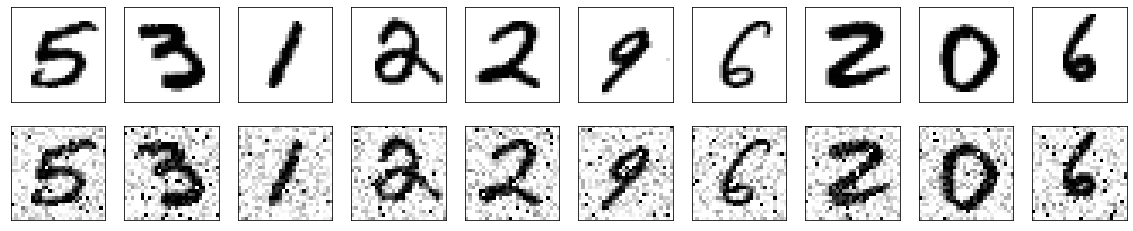

(120000, 28, 28)
(20000, 28, 28)


In [ ]:
train_data_inv = np.invert(train_data)
test_data_inv = np.invert(test_data)

noisy_train_data_inv = noise(train_data_inv)
noisy_test_data_inv = noise(test_data_inv)
dis(train_data_inv, noisy_train_data_inv)

train_data = np.vstack((train_data, train_data_inv))
test_data = np.vstack((test_data, test_data_inv))
noisy_train_data = np.vstack((noisy_train_data, noisy_train_data_inv))
noisy_test_data = np.vstack((noisy_test_data, noisy_test_data_inv))

print(train_data.shape)
print(test_data.shape)

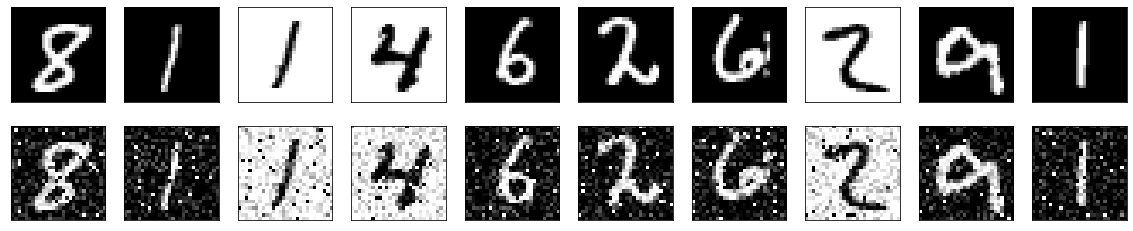

In [ ]:
dis(train_data, noisy_train_data)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

tf.random.set_seed(6969)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  0


[]

### Building the ANN

In [ ]:
input = layers.Input(shape=(28, 28, 1))



autoencoder = keras.Sequential([
    layers.Input(shape=(28, 28, 1)),
    #encoder
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2), padding="same"),
    #layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    #layers.MaxPooling2D((2, 2), padding="same"),
    
    #decoder
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"),
    #layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"),
    layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")
    
])

autoencoder.summary()





Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       9248      
 ranspose)                                                       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 1)         289       
                                                                 
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


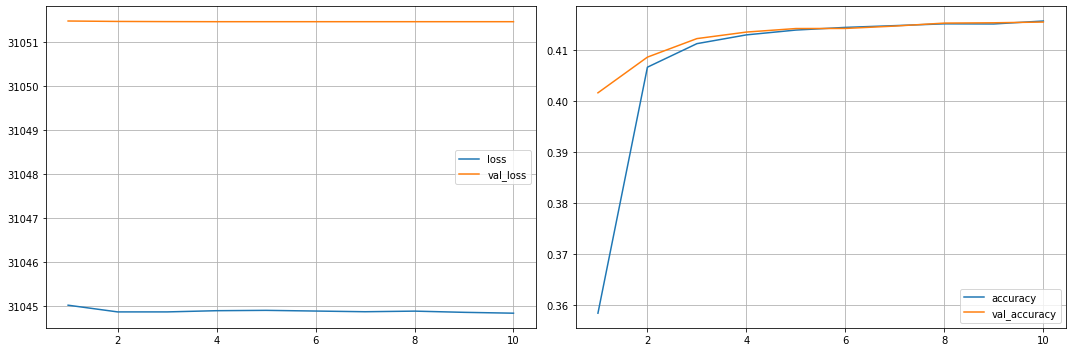

1875/1875 [==============================] - 240s 128ms/step - loss: 31044.8359 - accuracy: 0.4157 - val_loss: 31051.4629 - val_accuracy: 0.4155


In [ ]:
autoencoder.compile(optimizer="adam", 
            loss="MSE",
            metrics=['accuracy'])

callbacks_list = [PlotLearning()]
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=10,
    batch_size=64,
    #shuffle=True,
    validation_data=(test_data, test_data),
    callbacks=callbacks_list
)

Let's save the model

In [ ]:
autoencoder.save('autoencoder1.h5')

In [ ]:
denoiser = keras.Sequential([
    #encoder                        
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
    #layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
    
    #decoder
    #layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'), Those lines will break the code
    layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
    layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
    
])

denoiser.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 16)       2320      
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       4640      
 ranspose)                                                       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 1)         289       
                                                                 
Total params: 12,193
Trainable params: 12,193
Non-trai

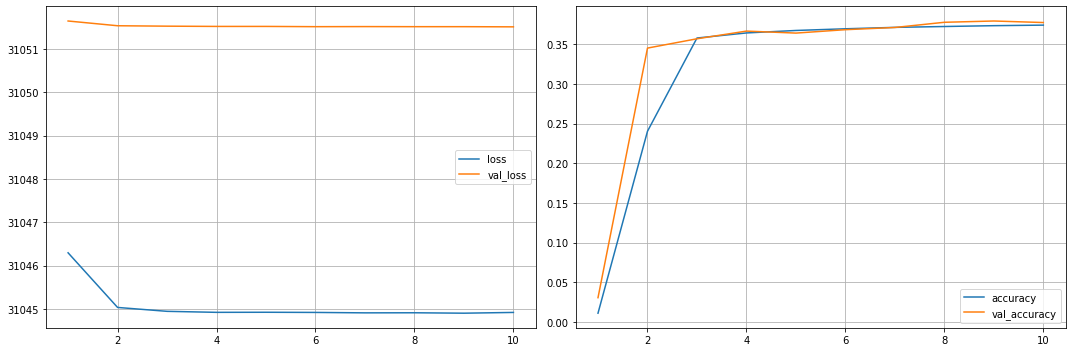

1875/1875 [==============================] - 218s 116ms/step - loss: 31044.9180 - accuracy: 0.3740 - val_loss: 31051.5137 - val_accuracy: 0.3773


In [ ]:
denoiser.compile(optimizer="adam", 
            loss="MSE",
            metrics=['accuracy'])

callbacks_list2 = [PlotLearning()]
denoiser.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=10,
    batch_size=64,
    #shuffle=True,
    validation_data=(noisy_test_data, test_data),
    callbacks=callbacks_list2
)

Let's save this model too.


In [ ]:
denoiser.save('denoiser.h5')

We do not have to train the model again since we already saved into our file, let's just load it.

In [ ]:
!sudo apt-get install python3-h5py

In [ ]:
from keras.models import load_model
autoencoder = load_model('autoencoder1.h5')


In [ ]:
autoencoder = load_model('autoencoder1.h5')
denoiser = load_model('denoiser.h5')

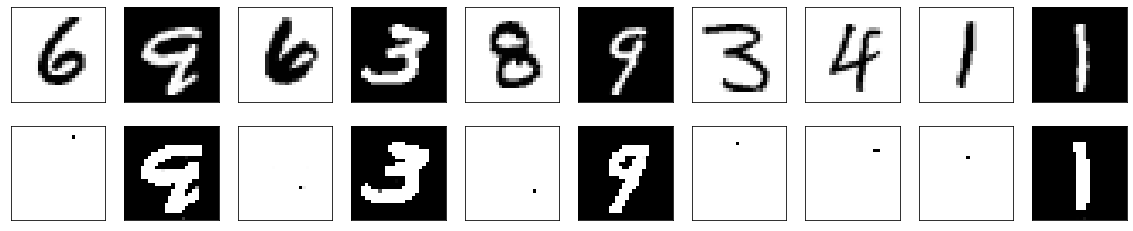

In [ ]:
predictions = autoencoder.predict(test_data)
dis(test_data, predictions)

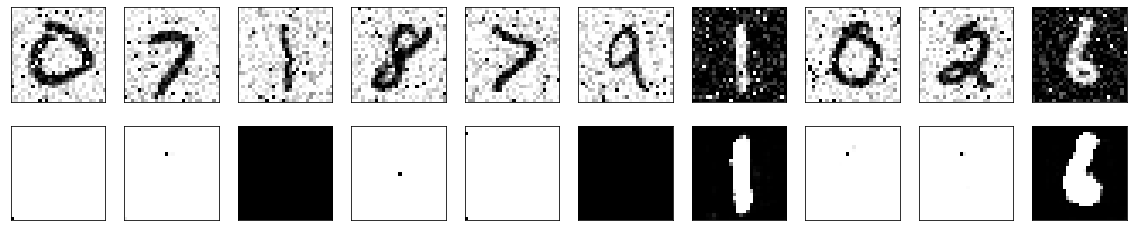

In [ ]:
predictions2 = denoiser.predict(noisy_test_data)
dis(noisy_test_data, predictions2)

Something went wrong with our model, It will fail the white background
.In this case, let me just use the black background image.

In [ ]:
(train_data, _), (test_data, _) = mnist.load_data()
print(train_data.shape)
# Normalize and reshape the data
print(train_data[0].shape)
print(type(train_data[0]))


# Add noise to the data
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

Let's test with my own images.

In [ ]:
# use my own function later on

In [ ]:

#!curl -o "nun.jpg" https://pbs.twimg.com/media/EW-X3HoXQAIVzWM?format=jpg&name=small
!curl -o "4.jpg" https://miro.medium.com/max/282/1*xpszL7jJrV5UTV7Xa-fgWQ.png

In [ ]:
import IPython.display as Display
image_path = "4.jpg"
Display.display(Display.Image(image_path))

img_raw = tf.io.read_file(image_path)



img_tensor = tf.image.decode_image(img_raw)
img_tensor = tf.image.rgb_to_grayscale(img_tensor)
print(img_tensor.shape)
print(img_tensor.dtype)



img_final = tf.image.resize(img_tensor, [28,28])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

In [ ]:
# change 28*28*3 into 28*28*1 
img_final_s = img_final.numpy().squeeze()
plt.imshow(img_final_s)
plt.title(image_path)

In [ ]:
noise_4 = noise(img_final_s)
plt.imshow(noise_4)
plt.title(image_path+" - noise")
print(noise_4.shape)

In [ ]:
#noise_nun = (np.expand_dims(noise_nun,0))
def pp(x):
    img =np.expand_dims(x, axis=0)
    new_img = np.vstack([img])
    
    return new_img

pred_4 = autoencoder2.predict(pp(noise_4))
pred_4 = pred_4.reshape(28,28)
print(noise_4.shape)
print(pred_4.shape)
plt.subplot(1,2,1)
plt.imshow(noise_4)
plt.subplot(1,2,2)
plt.imshow(pred_4)

In [ ]:
plot_list = [ pred_4[0].squeeze(),img_final_s]
plt.figure(figsize=(14,8))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(plot_list[i])
plt.title("Prediction vs. Ground Truth",loc='left')
plt.tight_layout()
plt.show()